# Build and Train Decision Trees for Classification Problems
## Purpose
In this example we will demonstrate how to:
   - Build a coreset tree for classification decision trees based on a real-world MultiClass dataset.
   - Perform coreset tree vs. entire train dataset vs. random selection comparison as follows:
      - Build a CatBoostClassifier model using the coreset tree method
      - Build a CatBoostClassifier model on the entire train dataset.
      - Build a CatBoostClassifier model on a randomly-sampled train dataset, where the sample size exactly matches coreset size.
      - Build a CatBoostClassifier model on a randomly-sampled train dataset, where the sample size is large-enough to strive to match the quality of using the coreset from the coreset tree.
      - Compare the quality of all four models built.
   - Employ coreset tree's utility functions for saving, loading and plotting the coreset tree.

For the example dataset, we will be using the PokerHand OpenML dataset (https://www.openml.org/search?type=data&status=active&id=155).
The data will be split into 'train' and 'test' portions using sklearn's train/test split (80% for the train portion, 20% for the test).
The 'train' portion will consist of roughly 663K samples, and the 'test' portion will have around 166K samples.
Our comparisons will utilize the balanced accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) as the evaluation metric.


In [ ]:
import os
import warnings
from time import time
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier 

from dataheroes import CoresetTreeServiceDTC, DataTuningParamsClassification

warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)

## 1. Prepare the dataset & the testing environment

In [2]:
# Load PokerHand dataset as X, y (data, target) from openml.
X, y = fetch_openml("pokerhand", return_X_y=True)

# Label-Encode the target. We do so because, further down the road, we will use Catboost for
# modeling, which requires consecutive integer labels starting from 0.
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

# Merge 3 class labels into a single label, to make the data-set have only 5 targets.
# (Otherwise, the smaller class is made up of only 2 samples, and the last but one - with only 11.)
y[y > 3] = 4

# Split to train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Get categorical features indices from training data.
cat_features = X_train.select_dtypes(include=['category', 'object']).columns
cat_features_indices = [X_train.columns.get_loc(cat) for cat in cat_features]

#Convert the data to ndarray.
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Remember the number of classes (5) required for the upcoming training code.
num_classes = len(np.unique(y_train))
print(f"#classes={num_classes}, train size={len(X_train):,}, test size={len(X_test):,}")

# Define the number of estimators for Catboost.
# The higher the number of estimators, the better the results will be (but the longer the time will take).
n_estimators = 100

# Set the tree access level which we will be working with (default is 0=root node).
tree_query_level = 2

# Remember the number of samples for the full dataset.
n_samples_full = len(y_train)

# Define the number of samples for the comparison flavour in which a randomly-selected dataset is striving to resemble coreset dataset's quality.
n_samples_rand_large = int(n_samples_full * 0.3)

# Define method for summarizing every flavour's experimental results in one neat table.
def produce_results(experiment_group : str,
                    n_samp_full : int, n_samp_rand_large : int, n_samp_coreset : int,
                    full_score : float, rand_large_score : float, rand_csize_score : float, coreset_score : float,
                    full_secs : float, rand_large_secs : float, rand_csize_secs : float, coreset_secs : float):

    df = pd.DataFrame(data={
        ' ': ['Full dataset', 'Random bigger-sized sample', 'Random smaller-sized sample', 'Coreset'],
        'Training dataset size': [n_samp_full, n_samp_rand_large, n_samp_coreset, n_samp_coreset],
        '% of full dataset': [n_samp_full / n_samp_full, n_samp_rand_large / n_samp_full, n_samp_coreset / n_samp_full, n_samp_coreset / n_samp_full],
        'Balanced accuracy score': [full_score, rand_large_score, rand_csize_score, coreset_score],
        'Training time (sec)': [full_secs, rand_large_secs, rand_csize_secs, coreset_secs],
    })
    last_row = pd.IndexSlice[df.index[-1], :]
    styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "120%"), ("font-weight", "bold")])]
    s  = df.style \
        .set_properties(subset=[' '],**{'text-align':'left'}) \
        .set_properties(subset=['Training dataset size','% of full dataset','Balanced accuracy score','Training time (sec)'],**{'text-align':'right'}) \
        .set_properties(subset=last_row, **{'color':'green', 'font-weight':'bold'}) \
        .set_caption(f"{experiment_group} Results") \
        .format({
        'Training dataset size': '{:,}',
        '% of full dataset': '{:.2%}',
        'Balanced accuracy score': '{:.4f}',
        'Training time (sec)': '{:.2f}'}) \
        .hide(axis='index') \
        .set_table_styles(styles)
    return s

#classes=5, train size=663,360, test size=165,841


## 2. Build the coreset tree
Create a new service object and run `build` directly on the X, y train data.
We pass `chunk_size` and `coreset_size` together with `n_instances` to initialize the coreset tree.

### 2.1. Build the coreset tree


In [ ]:
t = time()
# Define all columns as categorical, so they would be one-hot encoded by the dataheroes library.
# We explicitly set the model to CatBoostClassifier, as the default 
# model class is XGBClassifier in case XGBoost is installed 
data_params = {
    'categorical_features': cat_features,
    'ohe_min_frequency': 0
}
service_obj = CoresetTreeServiceDTC(optimized_for='training',
                                    n_instances=n_samples_full,
                                    chunk_size=n_samples_full//4,
                                    data_tuning_params=DataTuningParamsClassification(coreset_size=[20_000]),
                                    data_params=data_params,
                                    model_cls=CatBoostClassifier,
                                   )
service_obj.build(X_train, y_train,copy=True)
coreset_build_secs = time() - t
print(f"Coreset build time (sec): {coreset_build_secs:.2f}")

Coreset build time (sec): 6.91


### 2.2. Train the model using the coreset tree fit method

In [4]:
t = time()
# Ignore Catboost's warning about the requirement to pass the 'sample_weight' as a keyword arg and not as a positional arg.
warnings.filterwarnings(action='ignore', category=FutureWarning)


# Please note the direct usage of "service_obj.fit()".
# Provide the same parameters to the fit method as you'd provide for the model generation and for tree access (required tree level).
service_obj.fit(level=tree_query_level,
                objective='MultiClass',
                classes_count=num_classes,
                n_estimators=n_estimators,
                verbose=False
               )

coreset_secs = time() - t

Using CatBoostClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function


## 3. Training models using traditonal sampling methods

### 3.1. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [5]:
# Convert the data to dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [6]:
t = time()
# Train an Catboost model on the entire data-set.
full_model = CatBoostClassifier(objective='MultiClass',
                                                classes_count=num_classes,
                                                cat_features=cat_features_indices,
                                                verbose=False,
                                                n_estimators=n_estimators)
full_model.fit(X_train, y_train)
full_secs = time() - t

### 3.2. Train models on samples selected randomly from the training set

### 3.2.1. Produce a randomly-selected sample matching the coreset's size

In [ ]:
#We get the number of samples in the coreset, so we can randomly sample the same number of samples from the full dataset.
n_samples_coreset = service_obj.get_coreset_size(tree_idx=0, level=tree_query_level)

t = time()
# Train an Catboost model on the random data-set -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
rand_csize_model = CatBoostClassifier(objective='MultiClass',
                                                classes_count=num_classes,
                                                cat_features=cat_features_indices,
                                                verbose=False,
                                                n_estimators=n_estimators)
rand_csize_idxs = np.random.choice(n_samples_full, n_samples_coreset, replace=False)
rand_csize_model.fit(X_train.iloc[rand_csize_idxs, :], y_train[rand_csize_idxs])
rand_csize_secs = time() - t

### 3.2.2. Produce a randomly-selected sample striving to match coreset's quality

In [8]:
t = time()
# Train an Catboost model on the random data-set -
# (1) Create the model, (2) randomly sample size larger than the coreset size, and (3) train the model.
rand_large_model = CatBoostClassifier(objective='MultiClass',
                                                      classes_count=num_classes,
                                                      cat_features=cat_features_indices,
                                                      n_estimators=n_estimators,
                                                      verbose=False
                                                      )
rand_large_idxs = np.random.choice(n_samples_full, n_samples_rand_large, replace=False)
rand_large_model.fit(X_train.iloc[rand_large_idxs, :], y_train[rand_large_idxs])
rand_large_secs = time() - t

## 4. Tree-based coreset performance comparison: coreset tree's default fit modeling approach



### 4.1. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [ ]:
# Evaluate models. Please note the direct usage of "service_obj.predict()".
full_score = balanced_accuracy_score(y_test, full_model.predict(X_test))
rand_large_score = balanced_accuracy_score(y_test, rand_large_model.predict(X_test))
rand_csize_score = balanced_accuracy_score(y_test, rand_csize_model.predict(X_test))
coreset_score = balanced_accuracy_score(y_test, service_obj.predict(X_test.values))
produce_results("CatBoostClassifier",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                full_score, rand_large_score, rand_csize_score, coreset_score,
                full_secs, rand_large_secs, rand_csize_secs, coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9189,60.41
Random bigger-sized sample,"199,008",30.00%,0.9072,18.29
Random smaller-sized sample,"74,232",11.19%,0.8458,7.88
Coreset,"74,232",11.19%,0.9237,9.36


## 5. Tree utilities

### 5.1. Save the tree for future use

In [10]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

WindowsPath('output/train_coreset_tree')

### 5.2. Load the saved tree

In [11]:
service_obj = CoresetTreeServiceDTC.load(out_dir, save_tree_name)

### 5.3. Plot the tree
Plot the tree to show the loading from files was properly done and to visualize the way the data is structured inside it.

{'training': WindowsPath('output/training_tree_20231128_080352.png')}

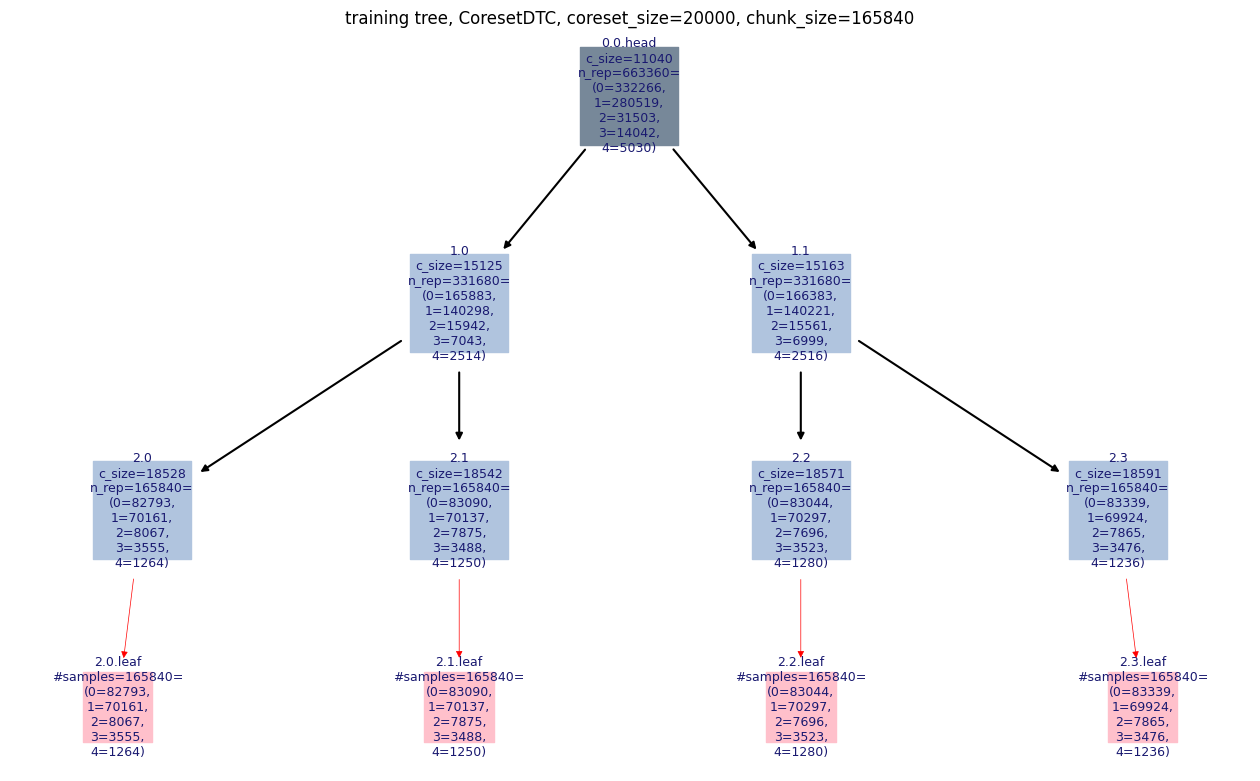

In [12]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir)

### 5.4. Save coreset for future use

In [13]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.get_coreset(as_df=True, with_index=True, save_path=final_coreset_path)